In [105]:
# Import necessary libraries
import os
import pydicom
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.ndimage import rotate, zoom, shift, binary_erosion, binary_dilation
from scipy.optimize import least_squares, minimize



# Normalization function
def normalize(input_array):
    amin = np.amin(input_array)
    amax = np.amax(input_array)
    return (input_array - amin) / (amax - amin)

img_phantom shape: (193, 229, 193)
Scan shape: (212, 512, 512)
Loading finished...
scan_3d_rescaled (212, 260, 260)
Cropped: (193, 229, 193)
Final img_phantom shape: (193, 229, 193)
Final scan_3d shape: (193, 229, 193)


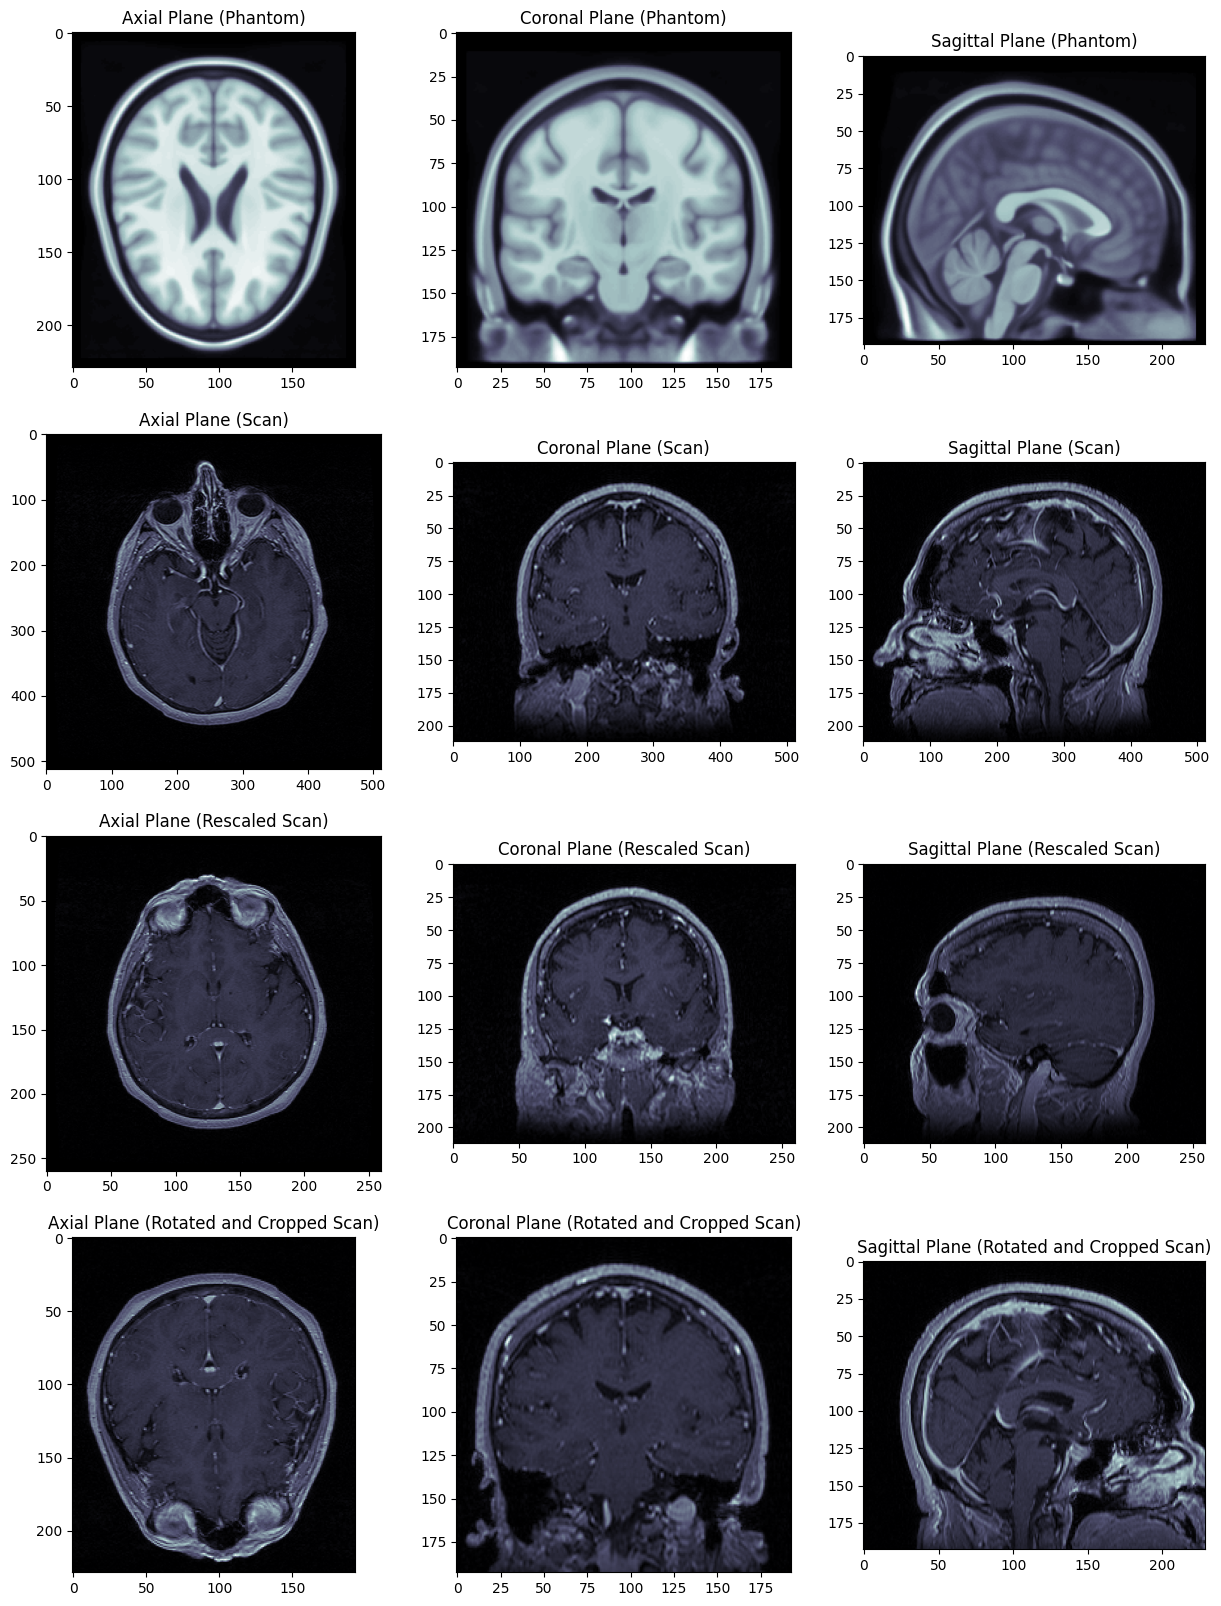

In [246]:
import cv2
import scipy

# Load the phantom image
phantom_dir = 'task2_data/icbm_avg_152_t1_tal_nlin_symmetric_VI.dcm'
tgt_dir = 'task2_data/RM_Brain_3D-SPGR'

# Load the phantom image
dcm_phantom = pydicom.dcmread(phantom_dir)
img_phantom = dcm_phantom.pixel_array

# Rotate the phantom image to correct orientation
img_phantom = rotate(img_phantom, 180, axes=(0, 2), reshape=False)

# Load and sort the DICOM files in the target directory
img_dcmset = []
for root, _, filenames in os.walk(tgt_dir):
    for filename in sorted(filenames):
        if filename.endswith(".dcm"):
            dcm_path = Path(root) / filename
            dicom = pydicom.dcmread(dcm_path, force=True)
            img_dcmset.append(dicom)

# Ensure slice thickness and pixel spacing are set
if img_dcmset:
    slice_thickness_main = img_dcmset[0].SliceThickness
    pixel_spacing_main = img_dcmset[0].PixelSpacing[0]

# Sort the images by InstanceNumber in ascending order
img_dcmset.sort(key=lambda x: x.InstanceNumber)

# Stack the pixel arrays
img_pixelarray = np.stack([dcm.pixel_array for dcm in img_dcmset], axis=0)
# Reverse the stacking along axis 0 to match the reference image orientation
img_pixelarray = np.flip(img_pixelarray,axis=0)

# Normalize the image
img_phantom = normalize(img_phantom)
print('img_phantom shape:', img_phantom.shape)

# Normalize the scan
scan_3d = normalize(img_pixelarray)
print('Scan shape:', scan_3d.shape)

print('Loading finished...')

# Visualize planes of img_phantom and img_pixelarray
fig, axs = plt.subplots(4, 3, figsize=(15, 20))

# img_phantom visualization
axs[0, 0].imshow(img_phantom[img_phantom.shape[0] // 2, :, :], cmap='bone', aspect=1)
axs[0, 0].set_title("Axial Plane (Phantom)")
axs[0, 1].imshow(img_phantom[:, img_phantom.shape[1] // 2, :], cmap='bone', aspect=1)
axs[0, 1].set_title("Coronal Plane (Phantom)")
axs[0, 2].imshow(img_phantom[:, :, img_phantom.shape[2] // 2], cmap='bone', aspect=1)
axs[0, 2].set_title("Sagittal Plane (Phantom)")

# scan_3d visualization
axs[1, 0].imshow(scan_3d[scan_3d.shape[0] // 2+15, :, :], cmap='bone', aspect=1)
axs[1, 0].set_title("Axial Plane (Scan)")
axs[1, 1].imshow(scan_3d[:, scan_3d.shape[1] // 2, :], cmap='bone', aspect=1/pixel_spacing_main)
axs[1, 1].set_title("Coronal Plane (Scan)")
axs[1, 2].imshow(scan_3d[:, :, scan_3d.shape[2] // 2], cmap='bone', aspect=1/pixel_spacing_main)
axs[1, 2].set_title("Sagittal Plane (Scan)")

scaling_factors = (1, pixel_spacing_main, pixel_spacing_main)
scan_3d_rescaled = zoom(scan_3d, scaling_factors, order=1)
print('scan_3d_rescaled', scan_3d_rescaled.shape)

# # Zoom out a bit
# zoom_factors = (0.91, 0.91, 0.91)
# scan_3d_rescaled = zoom(scan_3d_rescaled, zoom_factors, order=1)
# print('Zoom out scan_3d_rescaled', scan_3d_rescaled.shape)

# Rotate the scan_3d_rescaled image
angle_in_degrees = 180
scan_3d_rotated = rotate(scan_3d_rescaled, angle_in_degrees, axes=(1, 2), reshape=False)

# Crop
scan_3d_cropped = scan_3d_rotated[:-19, 8:237, 32:225]
print('Cropped:', scan_3d_cropped.shape)
phantom_shape = img_phantom.shape

print('Final img_phantom shape:', img_phantom.shape)
print('Final scan_3d shape:', scan_3d_cropped.shape)

# scan_3d_rescaled visualization
axs[2, 0].imshow(scan_3d_rescaled[phantom_shape[0] // 2+7, :, :], cmap='bone', aspect=1)
axs[2, 0].set_title("Axial Plane (Rescaled Scan)")
axs[2, 1].imshow(scan_3d_rescaled[:, phantom_shape[1] // 2, :], cmap='bone', aspect=1)
axs[2, 1].set_title("Coronal Plane (Rescaled Scan)")
axs[2, 2].imshow(scan_3d_rescaled[:, :, phantom_shape[2] // 2], cmap='bone', aspect=1)
axs[2, 2].set_title("Sagittal Plane (Rescaled Scan)")


# scan_3d_rotated visualization
axs[3, 0].imshow(scan_3d_cropped[phantom_shape[0] // 2+7, :, :], cmap='bone', aspect=1)
axs[3, 0].set_title("Axial Plane (Rotated and Cropped Scan)")
axs[3, 1].imshow(scan_3d_cropped[:, phantom_shape[1] // 2, :], cmap='bone', aspect=1)
axs[3, 1].set_title("Coronal Plane (Rotated and Cropped Scan)")
axs[3, 2].imshow(scan_3d_cropped[:, :, phantom_shape[2] // 2], cmap='bone', aspect=1)
axs[3, 2].set_title("Sagittal Plane (Rotated and Cropped Scan)")

plt.show()


Coregistration

[-5.43923140e+00 -1.64225025e+00 -6.13953434e-04  4.00000000e-02
  0.00000000e+00  5.00000000e-03  1.00000000e+00  1.00000000e+00
  1.00000000e+00]
[-5.43923148e+00 -1.64225025e+00 -6.13953434e-04  4.00000000e-02
  0.00000000e+00  5.00000000e-03  1.00000000e+00  1.00000000e+00
  1.00000000e+00]
[-5.43923140e+00 -1.64225027e+00 -6.13953434e-04  4.00000000e-02
  0.00000000e+00  5.00000000e-03  1.00000000e+00  1.00000000e+00
  1.00000000e+00]
[-5.43923140e+00 -1.64225025e+00 -6.13968335e-04  4.00000000e-02
  0.00000000e+00  5.00000000e-03  1.00000000e+00  1.00000000e+00
  1.00000000e+00]
[-5.43923140e+00 -1.64225025e+00 -6.13953434e-04  4.00000149e-02
  0.00000000e+00  5.00000000e-03  1.00000000e+00  1.00000000e+00
  1.00000000e+00]
[-5.43923140e+00 -1.64225025e+00 -6.13953434e-04  4.00000000e-02
  1.49011612e-08  5.00000000e-03  1.00000000e+00  1.00000000e+00
  1.00000000e+00]
[-5.43923140e+00 -1.64225025e+00 -6.13953434e-04  4.00000000e-02
  0.00000000e+00  5.00001490e-03  1.00000000e+0

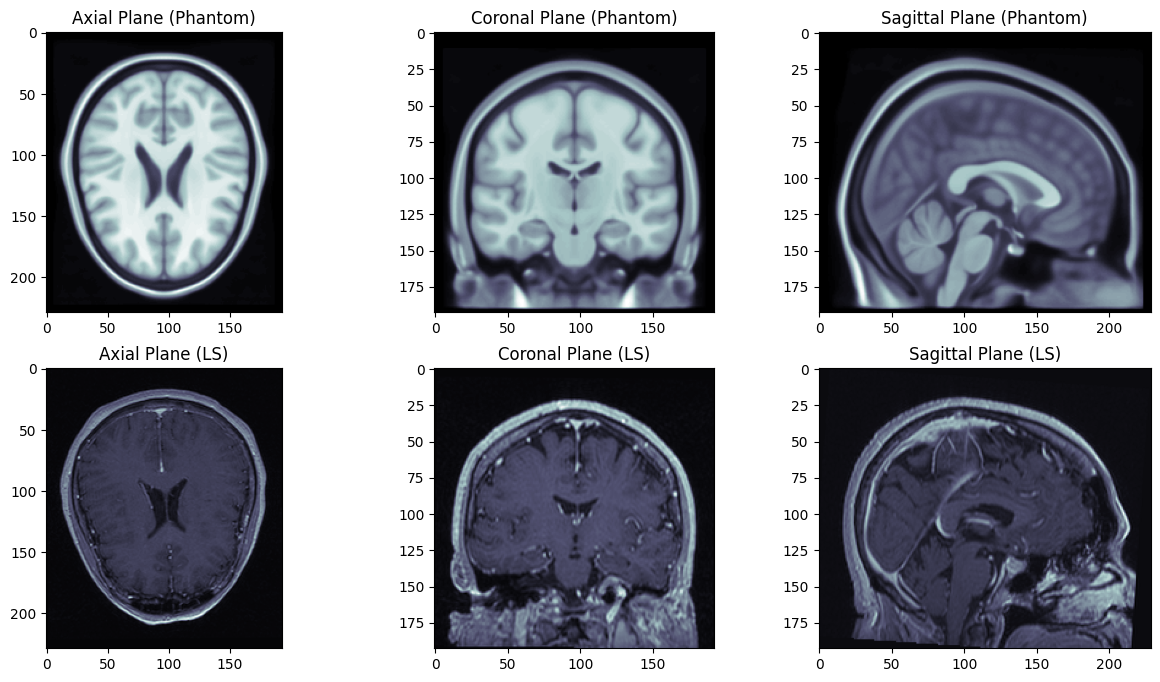

In [220]:
# Function for rotation
def rotate_all_axis(image, angles):
    axes = [(1, 2), (0, 2), (0, 1)]
    for angle, axis in zip(angles, axes):
        image = rotate(image, angle, axes=axis, reshape=False)
    return image

# Find the centroid of a volume
def find_centroid(img: np.ndarray):
    idcs = np.where(img > 0)
    centroid = np.stack([
        np.mean(idcs[0]),
        np.mean(idcs[1]),
        np.mean(idcs[2]),
    ])
    return centroid


def coregisteration(ref_image, inp_image):
    centroid_ref = find_centroid(ref_image)
    centroid_inp = find_centroid(inp_image)

    translation_vector = centroid_inp - centroid_ref
    initial_parameters = [translation_vector[0], translation_vector[1], translation_vector[2],
                          0.04, 0, 0.005, # rotate
                          1,1,1]   # zoom

    def function_to_minimize(parameters):
        print(parameters)
        translated_img = shift(inp_image, parameters[:3])
        rotated_img = rotate_all_axis(translated_img, parameters[3:6])
        zoomed_img = scipy.ndimage.zoom(rotated_img, parameters[6:], order=1)
        return np.mean(np.sqrt(((ref_image-zoomed_img))**2))

    result = least_squares(function_to_minimize, x0=initial_parameters, verbose=1)

    return result


# Normalize images
normalized_phantom = normalize(img_phantom)
normalized_scan = normalize(scan_3d_cropped)

# Perform coregistration using least squares
result_ls = coregisteration(normalized_phantom, normalized_scan)
params_ls = result_ls.x

# Apply the transformation with the found parameters
transformed_img_ls = shift(normalized_scan, params_ls[:3])
transformed_img_ls = rotate_all_axis(transformed_img_ls, params_ls[3:])
transformed_img_ls = scipy.ndimage.zoom(transformed_img_ls, params_ls[6:], order=1)

# Visualize the results of coregistration
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

axs[0, 0].imshow(img_phantom[img_phantom.shape[0] // 2, :, :], cmap='bone', aspect=1)
axs[0, 0].set_title("Axial Plane (Phantom)")
axs[0, 1].imshow(img_phantom[:, img_phantom.shape[1] // 2, :], cmap='bone', aspect=1)
axs[0, 1].set_title("Coronal Plane (Phantom)")
axs[0, 2].imshow(img_phantom[:, :, img_phantom.shape[2] // 2], cmap='bone', aspect=1)
axs[0, 2].set_title("Sagittal Plane (Phantom)")

# Least squares visualization
axs[1, 0].imshow(transformed_img_ls[phantom_shape[0] // 2, :, :], cmap='bone', aspect=1)
axs[1, 0].set_title("Axial Plane (LS)")
axs[1, 1].imshow(transformed_img_ls[:, phantom_shape[1] // 2, :], cmap='bone', aspect=1)
axs[1, 1].set_title("Coronal Plane (LS)")
axs[1, 2].imshow(transformed_img_ls[:, :, phantom_shape[2] // 2], cmap='bone', aspect=1)
axs[1, 2].set_title("Sagittal Plane (LS)")
plt.show()

Thalamus

In [221]:
params_ls

array([ 6.33237079, -7.39226082,  0.66662729,  0.52221134, -0.64292373,
       -3.92634334,  1.        ,  1.        ,  1.        ])

Phantom shape: (193, 229, 193)
Atlas shape: (181, 217, 181)
Cropped Phantom shape: (181, 217, 181)
Thalamus Mask Max Value: 1


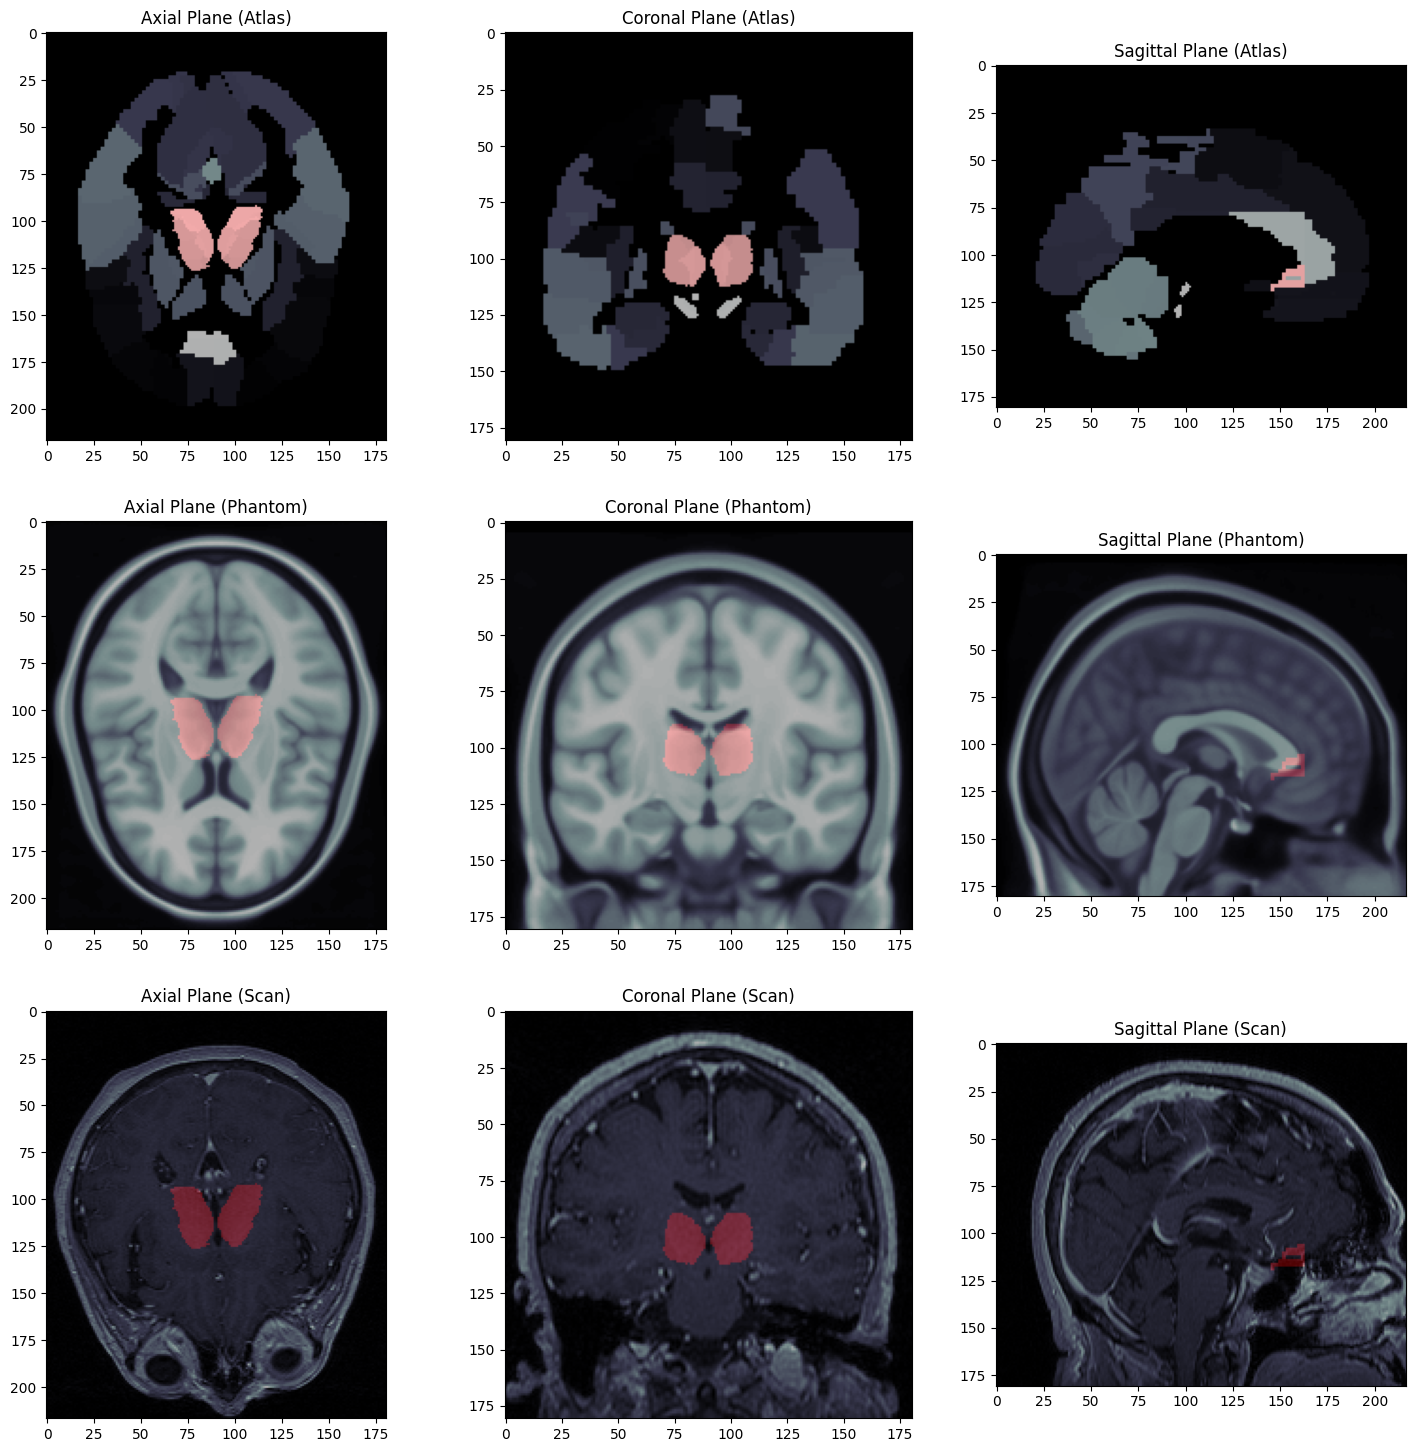

In [259]:
import numpy as np
import pydicom
from scipy.ndimage import rotate, shift
import matplotlib.pyplot as plt

# Load Atlas and Phantom images
atlas_path = 'task2_data/AAL3_1mm.dcm'
phantom_path = 'task2_data/icbm_avg_152_t1_tal_nlin_symmetric_VI.dcm'
dcm_atlas = pydicom.dcmread(atlas_path)
dcm_phantom = pydicom.dcmread(phantom_path)
img_atlas = dcm_atlas.pixel_array
img_phantom = dcm_phantom.pixel_array

img_atlas = rotate(img_atlas, 180, axes=(0, 2), reshape=False)
img_phantom = rotate(img_phantom, 180, axes=(0, 2), reshape=False)

# Normalize the images
def min_max_normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))

img_phantom = min_max_normalize(img_phantom)

# Print shapes
print('Phantom shape:', img_phantom.shape)
print('Atlas shape:', img_atlas.shape)

# Function to crop the image to match the target shape by extracting the center
def crop_center(img, target_shape):
    start = [(img_dim - tgt_dim) // 2 for img_dim, tgt_dim in zip(img.shape, target_shape)]
    end = [start[i] + target_shape[i] for i in range(len(start))]
    slices = tuple(slice(start[i], end[i]) for i in range(len(start)))
    return img[slices]

# Crop the phantom image to match the atlas shape
img_phantom_cropped = crop_center(img_phantom, img_atlas.shape)
print('Cropped Phantom shape:', img_phantom_cropped.shape)

# Function to create the thalamus mask from atlas
def create_thalamus_mask(atlas_img):
    mask = np.zeros_like(atlas_img)
    mask[(atlas_img >= 121) & (atlas_img <= 151)] = 1
    return mask

# Function to find centroid of a given mask
def find_centroid(mask: np.ndarray) -> np.ndarray:
    idcs = np.where(mask == 1)
    centroid = np.stack([
        np.mean(idcs[0]),
        np.mean(idcs[1]),
        np.mean(idcs[2]),
    ])
    return centroid

# Create the thalamus mask from the atlas
thalamus_mask = create_thalamus_mask(img_atlas)

# Find the centroid of the thalamus mask
try:
    thalamus_centroid = find_centroid(thalamus_mask)
except ValueError as e:
    print(e)
    thalamus_centroid = np.array([0, 0, 0])  # Set to origin if no centroid found

print("Thalamus Mask Max Value:", thalamus_mask.max())

# Define transformation and inverse transformation functions
def rotate_all_axis(image, angles):
    axes = [(1, 2), (0, 2), (0, 1)]
    for angle, axis in zip(angles, axes):
        image = rotate(image, angle, axes=axis, reshape=False)
    return image

def undo_transformation(mask, parameters):
    transformed_mask = mask.copy()
    transformed_mask = rotate_all_axis(transformed_mask, [-parameters[3], -parameters[4], -parameters[5]])
    transformed_mask = shift(transformed_mask, -np.array(parameters[:3]))
    return transformed_mask

# Apply inverse transformation to the thalamus mask
transformed_thalamus_mask = undo_transformation(thalamus_mask, params_ls)

# Calculate the centroid of the transformed thalamus mask
transformed_centroid = find_centroid(transformed_thalamus_mask)

scan = crop_center(scan_3d_cropped, img_atlas.shape)

# Function to blend images
def blend_images(image, mask, alpha=0.3):
    cmap = plt.cm.bone
    norm = plt.Normalize(vmin=np.amin(image), vmax=np.amax(image))
    colored_image = cmap(norm(image))[..., :3]

    colored_mask = np.zeros_like(colored_image)
    colored_mask[mask == 1] = [1, 0, 0]  # Red color for mask

    blended = (1 - alpha) * colored_image + alpha * colored_mask
    return blended


# Visualization for all three axes
fig, axs = plt.subplots(3, 3, figsize=(18, 18))

# Atlas Visualization
axs[0, 0].imshow(blend_images(img_atlas[int(thalamus_centroid[0]), :, :], thalamus_mask[int(thalamus_centroid[0]), :, :]), cmap='bone')
axs[0, 0].set_title("Axial Plane (Atlas)")

axs[0, 1].imshow(blend_images(img_atlas[:, int(thalamus_centroid[1]), :], thalamus_mask[:, int(thalamus_centroid[1]), :]), cmap='bone')
axs[0, 1].set_title("Coronal Plane (Atlas)")

axs[0, 2].imshow(blend_images(img_atlas[:, :, int(thalamus_centroid[2])], thalamus_mask[:, :, int(thalamus_centroid[2])]), cmap='bone')
axs[0, 2].set_title("Sagittal Plane (Atlas)")

# Phantom Visualization
axs[1, 0].imshow(blend_images(img_phantom_cropped[int(thalamus_centroid[0]), :, :], thalamus_mask[int(thalamus_centroid[0]), :, :]), cmap='bone')
axs[1, 0].set_title("Axial Plane (Phantom)")

axs[1, 1].imshow(blend_images(img_phantom_cropped[:, int(thalamus_centroid[1]), :], thalamus_mask[:, int(thalamus_centroid[1]), :]), cmap='bone')
axs[1, 1].set_title("Coronal Plane (Phantom)")

axs[1, 2].imshow(blend_images(img_phantom_cropped[:, :, int(thalamus_centroid[2])], thalamus_mask[:, :, int(thalamus_centroid[2])]), cmap='bone')
axs[1, 2].set_title("Sagittal Plane (Phantom)")

# Scan Visualization
axs[2, 0].imshow(blend_images(scan[int(transformed_centroid[0]), :, :], transformed_thalamus_mask[int(transformed_centroid[0]), :, :]), cmap='bone')
axs[2, 0].set_title("Axial Plane (Scan)")

axs[2, 1].imshow(blend_images(scan[:, int(transformed_centroid[1]), :], transformed_thalamus_mask[:, int(transformed_centroid[1]), :]), cmap='bone')
axs[2, 1].set_title("Coronal Plane (Scan)")

axs[2, 2].imshow(blend_images(scan[:, :, int(transformed_centroid[2])], transformed_thalamus_mask[:, :, int(transformed_centroid[2])]), cmap='bone')
axs[2, 2].set_title("Sagittal Plane (Scan)")

plt.show()


Optimized Parameters (Newton-CG): [-5.43923140e+00 -1.64225025e+00 -6.13953434e-04  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00]


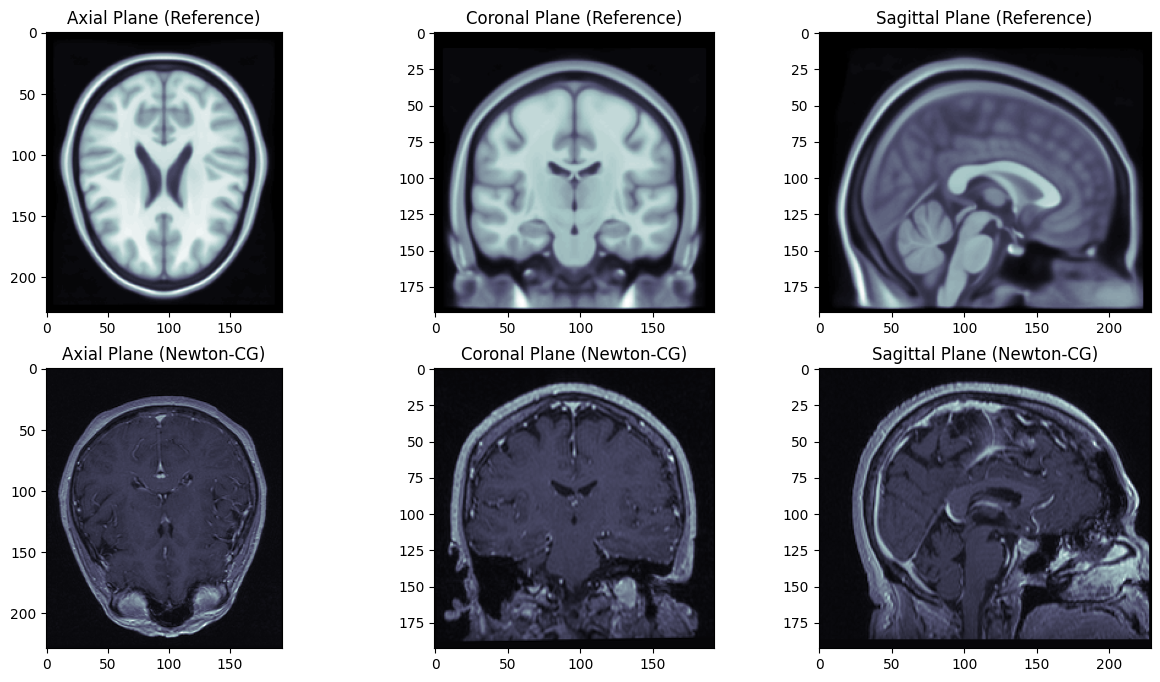

In [256]:
# Mean squared error loss function
def mse(ref_img, inp_img):
    return np.mean((ref_img - inp_img) ** 2)

# Gradient of the MSE loss function
def gradient_mse(ref_image, inp_image, parameters, epsilon=1e-5):
    grad = np.zeros_like(parameters)
    for i in range(len(parameters)):
        params_eps = np.array(parameters)
        params_eps[i] += epsilon

        transformed_img = shift(inp_image, params_eps[:3])
        transformed_img = rotate_all_axis(transformed_img, params_eps[3:])

        grad[i] = (mse(ref_image, transformed_img) - mse(ref_image, inp_image)) / epsilon

    return grad

# Coregistration using Newton-CG method
def coregistration(ref_image, inp_image):
    c_ref = np.mean(np.argwhere(ref_image != 0), axis=0)
    c_inp = np.mean(np.argwhere(inp_image != 0), axis=0)

    translation_vector = c_inp - c_ref
    initial_parameters = [
        translation_vector[0], translation_vector[1], translation_vector[2],
        0, 1, 0, 0
    ]

    def function_to_minimize(parameters):
        translated_img = shift(inp_image, parameters[:3])
        rotated_img = rotate_all_axis(translated_img, parameters[3:])
        return mse(ref_image, rotated_img)

    def gradient_function(parameters):
        return gradient_mse(ref_image, inp_image, parameters)

    result = minimize(function_to_minimize, initial_parameters, method='Newton-CG', jac=gradient_function)
    return result

# Load and normalize the images
normalized_phantom = normalize(img_phantom)
normalized_scan = normalize(scan_3d_cropped)

# Perform coregistration using Newton-CG
result_nc = coregistration(normalized_phantom, normalized_scan)
params_nc = result_nc.x
print("Optimized Parameters (Newton-CG):", params_nc)

# Apply the transformation with the found parameters
def apply_transformation(image, params):
    transformed_image = shift(image, params[:3])
    transformed_image = rotate_all_axis(transformed_image, params[3:])
    return transformed_image

transformed_img_nc = apply_transformation(normalized_scan, params_nc)

# Visualize the results of coregistration
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

axs[0, 0].imshow(normalized_phantom[normalized_phantom.shape[0] // 2, :, :], cmap='bone', aspect=1)
axs[0, 0].set_title("Axial Plane (Reference)")
axs[0, 1].imshow(normalized_phantom[:, normalized_phantom.shape[1] // 2, :], cmap='bone', aspect=1)
axs[0, 1].set_title("Coronal Plane (Reference)")
axs[0, 2].imshow(normalized_phantom[:, :, normalized_phantom.shape[2] // 2], cmap='bone', aspect=1)
axs[0, 2].set_title("Sagittal Plane (Reference)")

# Newton-CG visualization
axs[1, 0].imshow(transformed_img_nc[normalized_phantom.shape[0] // 2, :, :], cmap='bone', aspect=1)
axs[1, 0].set_title("Axial Plane (Newton-CG)")
axs[1, 1].imshow(transformed_img_nc[:, normalized_phantom.shape[1] // 2, :], cmap='bone', aspect=1)
axs[1, 1].set_title("Coronal Plane (Newton-CG)")
axs[1, 2].imshow(transformed_img_nc[:, :, normalized_phantom.shape[2] // 2], cmap='bone', aspect=1)
axs[1, 2].set_title("Sagittal Plane (Newton-CG)")
plt.show()


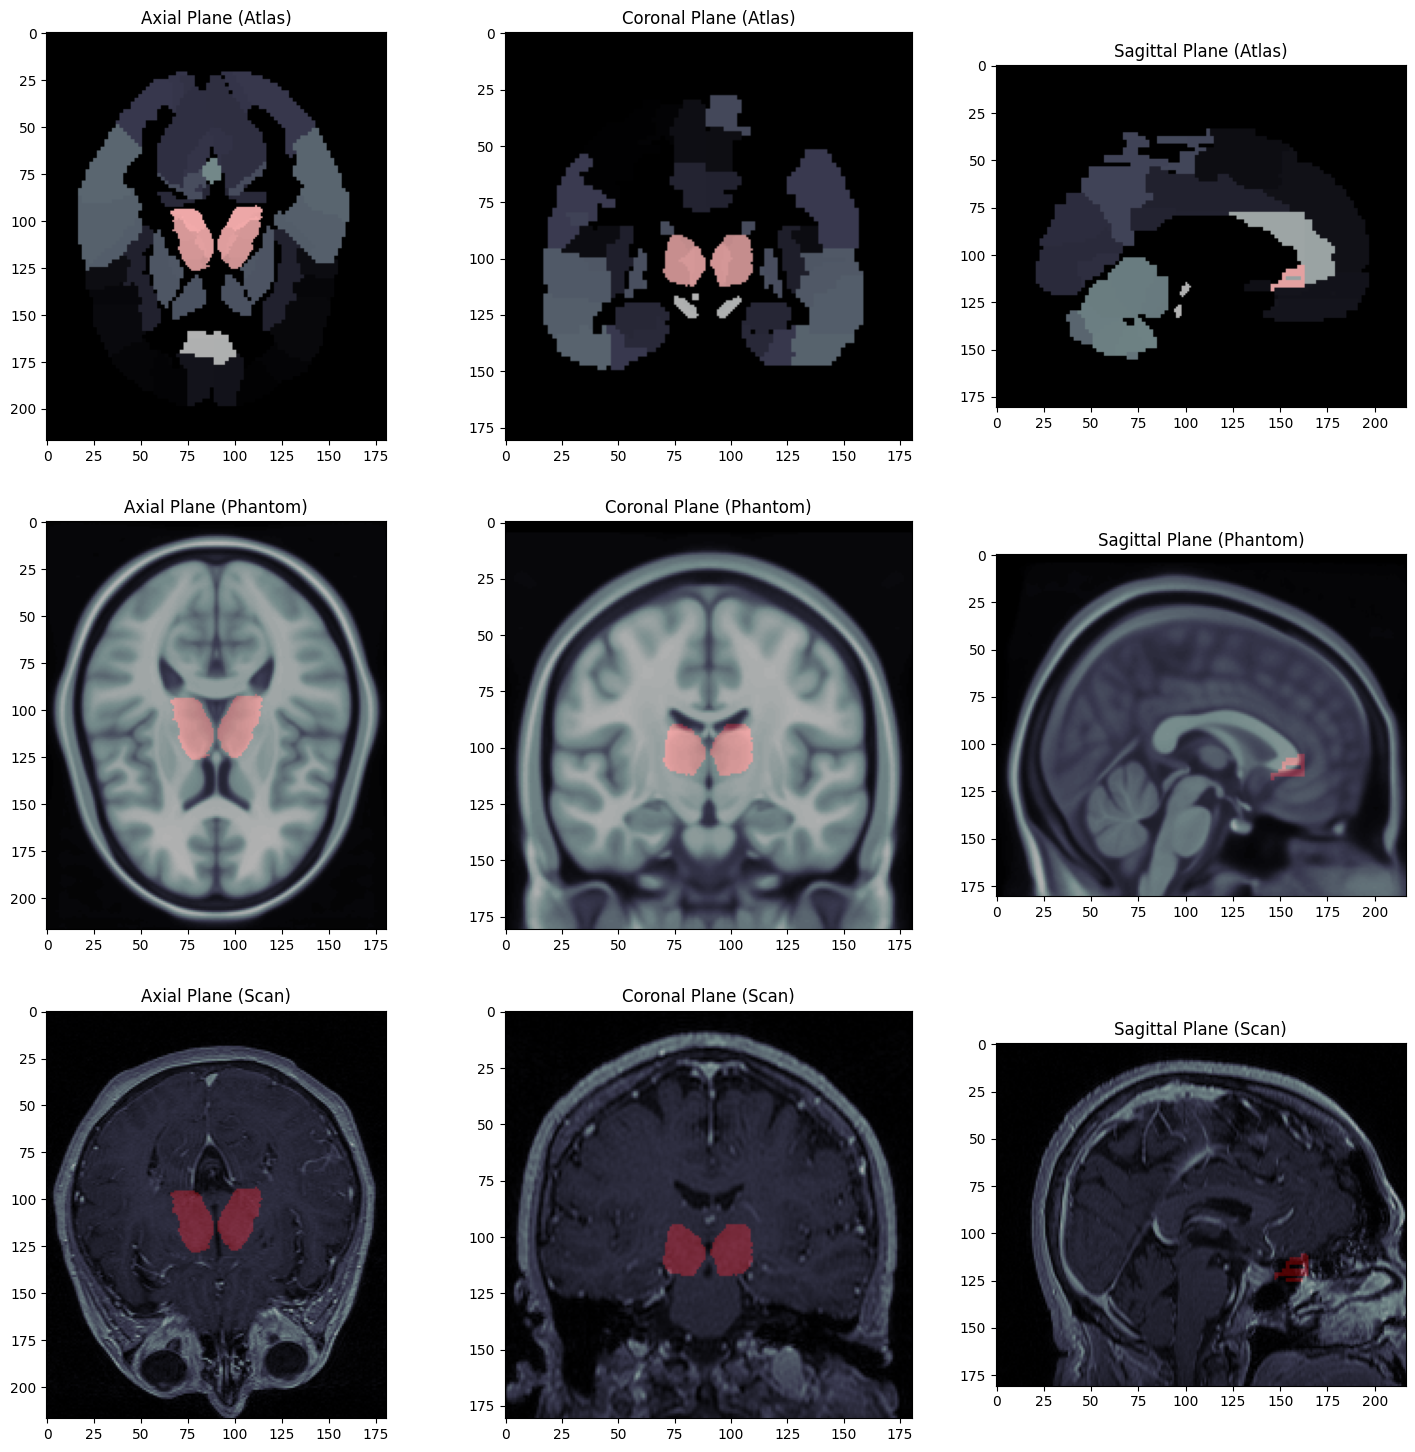

In [260]:
# Apply inverse transformation to the thalamus mask
transformed_thalamus_mask = undo_transformation(thalamus_mask, params_nc)

# Calculate the centroid of the transformed thalamus mask
transformed_centroid = find_centroid(transformed_thalamus_mask)

# Visualization for all three axes
fig, axs = plt.subplots(3, 3, figsize=(18, 18))

# Atlas Visualization
axs[0, 0].imshow(blend_images(img_atlas[int(thalamus_centroid[0]), :, :], thalamus_mask[int(thalamus_centroid[0]), :, :]), cmap='bone')
axs[0, 0].set_title("Axial Plane (Atlas)")

axs[0, 1].imshow(blend_images(img_atlas[:, int(thalamus_centroid[1]), :], thalamus_mask[:, int(thalamus_centroid[1]), :]), cmap='bone')
axs[0, 1].set_title("Coronal Plane (Atlas)")

axs[0, 2].imshow(blend_images(img_atlas[:, :, int(thalamus_centroid[2])], thalamus_mask[:, :, int(thalamus_centroid[2])]), cmap='bone')
axs[0, 2].set_title("Sagittal Plane (Atlas)")

# Phantom Visualization
axs[1, 0].imshow(blend_images(img_phantom_cropped[int(thalamus_centroid[0]), :, :], thalamus_mask[int(thalamus_centroid[0]), :, :]), cmap='bone')
axs[1, 0].set_title("Axial Plane (Phantom)")

axs[1, 1].imshow(blend_images(img_phantom_cropped[:, int(thalamus_centroid[1]), :], thalamus_mask[:, int(thalamus_centroid[1]), :]), cmap='bone')
axs[1, 1].set_title("Coronal Plane (Phantom)")

axs[1, 2].imshow(blend_images(img_phantom_cropped[:, :, int(thalamus_centroid[2])], thalamus_mask[:, :, int(thalamus_centroid[2])]), cmap='bone')
axs[1, 2].set_title("Sagittal Plane (Phantom)")

# Scan Visualization
axs[2, 0].imshow(blend_images(scan[int(transformed_centroid[0]), :, :], transformed_thalamus_mask[int(transformed_centroid[0]), :, :]), cmap='bone')
axs[2, 0].set_title("Axial Plane (Scan)")

axs[2, 1].imshow(blend_images(scan[:, int(transformed_centroid[1]), :], transformed_thalamus_mask[:, int(transformed_centroid[1]), :]), cmap='bone')
axs[2, 1].set_title("Coronal Plane (Scan)")

axs[2, 2].imshow(blend_images(scan[:, :, int(transformed_centroid[2])], transformed_thalamus_mask[:, :, int(transformed_centroid[2])]), cmap='bone')
axs[2, 2].set_title("Sagittal Plane (Scan)")

plt.show()
